# Grupo 15

* De Blasis, Cristian
* Gudiño, Gabriel
* Milich-Tear, Guillermo
* Veiga, Cristian

## Vectorizacion

Para generar el diccionario utilizamos el siguiente embedding de palabras en español:
https://github.com/dccuchile/spanish-word-embeddings
*	Corpus:Spanish Unannotated Corpora
*	Algorithm: FastText
*	vectors: 1.313.423
*	vec-dim: 300
*	Credits: José Cañete


In [1]:
import pandas as pd
import numpy as np
import joblib
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

#Configuracion pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

In [2]:
df=joblib.load('./datasets/1_TOKEN')

FileNotFoundError: ignored

In [ ]:
word_vectors = KeyedVectors.load_word2vec_format('embeddings-l-model.vec', binary=False) 

In [ ]:
%%time
# Genero diccionario
dict_esp=set(word_vectors.index_to_key)

# Filtra palabras que estan en el diccionario
df['token_in_dict']=df['nota_token_limpia'].map(lambda lista:[w for w in lista if w in dict_esp])

# Borro los registros que me quedaron sin palabras
df=df[df['token_in_dict'].map(lambda x:len(x)>0)].reset_index(drop=True)

CPU times: total: 4.03 s
Wall time: 4.01 s


# Vector promedio

A fin de reducir la dimencionalidad de los vectores, realizamos un promedio. 
La idea es realizar luego una comparacion entre, este promedio y el promedio pesado.

In [ ]:
# Genero vectores por palabras
df['vector']=df['token_in_dict'].map(lambda w:word_vectors[w])

# Promedio los vectores
df['vector_promedio']=df['vector'].map(lambda matrix:matrix.mean(axis=0))

In [ ]:
joblib.dump(df[['id', 'fecha','vector_promedio','topico']], './datasets/2_VECTOR_PROM')

['./datasets/2_VECTOR_PROM']

# Vector promedios pesados con TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

Para saber si una palabra es "importante" en el contexto del documento. Utilizamos TFIDF.
Con este dato estaditico lo que hacemos es reconocer si una palabra es muy poco frecuente
Entonces la busqueda se centrara en documentos que contengan esa palabra.

Cálculo de frecuencia para la palabra:                                       feliz</br>
Cantidad de documentos por procesar:                                      100.000</br>
Cantidad total que aparece "feliz" en todos los documentos:    1.000</br>
Cantidad de palabras que tienen el documento evaluado:       100</br>
Cantidad total que aparece "feliz" en el documento evaluado: 5</br>
</br>
TF es la relación del número total de aparaciones en el documento que se esta evaluando.</br>
La frecuencia del termino (TF) para "feliz" es entonces (5/100) = 0.05</br>
</br>
IDF, por otro lado, es una relación de registro del número total de documentos a un documento que contiene una palabra en particular.</br>
La frecuencia inversa del documento (IDF) para "feliz" es entonces log (100.000 / 1.000) = 2</br>
</br>
Por lo tanto, el TF-IDF para "feliz" en el documento evaluado es: 0.05 * 2 = 0.10

https://towardsdatascience.com/nlp-performance-of-different-word-embeddings-on-text-classification-de648c6262b

https://gist.github.com/TomLin/30244bcccb7e4f94d191a878a697f698

In [ ]:
# se construye una nota con los datos tokenizados
df['nota']=df['token_in_dict'].map(lambda x:' '.join([word for word in x]))

In [ ]:
# df_1=df.sample(100).reset_index(drop=True).copy()
df_1=df.reset_index(drop=True).copy()

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df_1['nota'])

In [ ]:
%%time
# Se calcula TF-IDF para todo el documento
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df_1['nota'])

CPU times: total: 10.7 s
Wall time: 10.7 s


In [ ]:
%%time
# Se calcula un diccionario con los pesos de TF-IDF 

#Genera una lista de tuplas con la palabra de los documentos y su indice
# vectorizer.vocabulary_.items() 

#Genera una lista de tuplas con la palabra de los documentos y su peso
# [(w, vectorizer.idf_[i]) for w, i in vectorizer.vocabulary_.items()] 

# Genera un diccionario con los pesos
dic_weight={}
a=[dic_weight.setdefault(w, []).append(vectorizer.idf_[i]) for w, i in vectorizer.vocabulary_.items()]

CPU times: total: 7min 7s
Wall time: 7min 8s


In [ ]:
max_idf=max_idf = max(vectorizer.idf_)

In [ ]:
%%time
def get_idf(w,dic_weight):
    return dic_weight[w][0] if w in dic_weight else max_idf

df_1['vector_prom_pesado']=df_1.apply(lambda x:(
                                                    np.array([get_idf(w,dic_weight) for w in x['token_in_dict']]) #pesos por palabra
                                                    *x['vector'].T   # vector por palabra
                                            ).mean(axis=1)   # promedio, queda cada frase mapeada en 300 dimensiones
                                 ,axis=1)

CPU times: total: 27.1 s
Wall time: 27.5 s


In [ ]:
joblib.dump(df_1[['id', 'fecha','vector_prom_pesado','topico']], './datasets/2_VECTOR_PROM_PESADO')

['./datasets/2_VECTOR_PROM_PESADO']

# Analisis grafico de clases

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
import numpy as np

## Vector promedio

D:\ProgramData\Anaconda3\envs\wm_env\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\ProgramData\Anaconda3\envs\wm_env\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


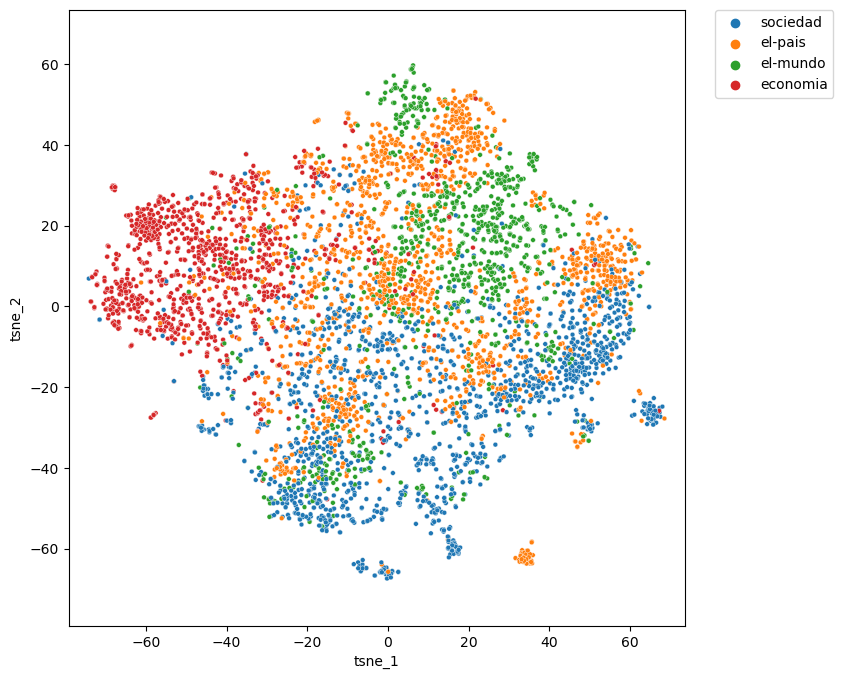

In [ ]:
n_components=2

y=df.sample(n=5000,random_state=1978)['topico']
X=df.sample(n=5000,random_state=1978)['vector_promedio'].to_list()

tsne=TSNE(n_components)
tsne_result=tsne.fit_transform(X)
tsne_result.shape

tsne_result_df=pd.DataFrame({'tsne_1':tsne_result[:,0] ,'tsne_2':tsne_result[:,1] ,'label':y})

# Grafica
fig,ax=plt.subplots(1)
fig.set_size_inches(10,8)
sns.scatterplot(x='tsne_1',y='tsne_2',hue='label',data=tsne_result_df,ax=ax,s=12)
lim=(tsne_result.min()-5,tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.0)

#### A primera vista notamos que las notas de economía estan mas cercanas, sin embargo el resto de los topicos se distribuyen de manera mas difusa. 

## Vector promedio pesado

D:\ProgramData\Anaconda3\envs\wm_env\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\ProgramData\Anaconda3\envs\wm_env\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


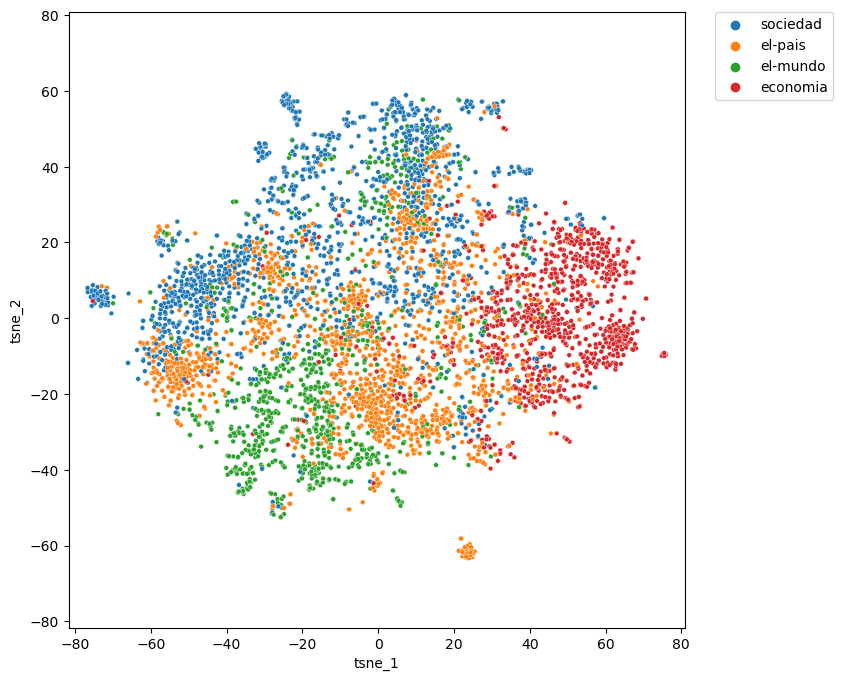

In [ ]:
n_components=2

y=df_1.sample(n=5000,random_state=1978)['topico']
X=df_1.sample(n=5000,random_state=1978)['vector_prom_pesado'].to_list()

tsne=TSNE(n_components)
tsne_result=tsne.fit_transform(X)
tsne_result.shape

tsne_result_df=pd.DataFrame({'tsne_1':tsne_result[:,0] ,'tsne_2':tsne_result[:,1] ,'label':y})

# Grafica
fig,ax=plt.subplots(1)
fig.set_size_inches(10,8)
sns.scatterplot(x='tsne_1',y='tsne_2',hue='label',data=tsne_result_df,ax=ax,s=12)
lim=(tsne_result.min()-5,tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.0)

#### Como podemos ver, si usamos el vector de promedio pesado, mejora muy poco el agrupamiento de las notas.